Script to load in and plot the RHESSI image archive fits
[https://hesperia.gsfc.nasa.gov/rhessi_extras/flare_images/hsi_flare_image_archive.html](https://hesperia.gsfc.nasa.gov/rhessi_extras/flare_images/hsi_flare_image_archive.html)

15-Jul-2020 IGH

In [1]:
from astropy.io import fits
import numpy as np
import astropy.time
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sunpy.visualization.colormaps as cm

import glob
import warnings
warnings.filterwarnings("ignore")


File we are using here is from

[https://hesperia.gsfc.nasa.gov/rhessi_extras/flare_images/2012/10/26/20121026_0812_0818/hsi_20121026_0812_0818.html](https://hesperia.gsfc.nasa.gov/rhessi_extras/flare_images/2012/10/26/20121026_0812_0818/hsi_20121026_0812_0818.html)

In [2]:
# Use glob to find more files
# mdir='/scratch/mokusei/iain/rfia/hesperia.gsfc.nasa.gov/rhessi_extras/imagecube_fits/'
# subdir='2012/10/26/'
# ff=glob.glob(mdir+subdir+'**/hsi_imagecube_clean_*.fits')
ff=glob.glob('hsi_imagecube_clean_*.fits')
print(ff)

['hsi_imagecube_clean_20121026_0812_4tx3e.fits']


In [3]:
fitsin=fits.open(ff[0])

In [4]:
# Images in [0]
imgs=fitsin[0].data
hdr=fitsin[0].header
print(imgs.shape)
nt,ne,nx,ny=imgs.shape
# So done as (t,e,x,y)
# for key in hdr:
#     print(key)
print(hdr['date'])

(4, 3, 101, 101)
2020-01-24T11:20:15


In [5]:
print(fitsin[2].columns.names)
print(fitsin[2].data['image_atten_state'])
snr=fitsin[2].data['SNR_VALUE']
print(snr)
tims=fitsin[2].data['ABSOLUTE_TIME_RANGE']
print(tims.shape,tims)
engs=fitsin[2].data['IM_EBAND_USED']
print(engs.shape,engs)
# Remeber to close the fits file after done with it
fitsin.close()

['SNR_VALUE', 'N_EVENT_USED', 'IMAGE_ATTEN_STATE', 'BINNED_N_EVENT', 'USED_XYOFFSET', 'ABSOLUTE_TIME_RANGE', 'IM_EBAND_USED', 'CBE_DET_EFF$$AVG', 'CBE_DET_EFF$$REL']
[0 0 0 0 0 0 0 0 0 0 0 0]
[ 4.963142   8.524233   3.6259823 10.5997925 16.728188   3.0338285
  8.2616005 10.483116   1.216235   5.357437   4.7075863  1.3652564]
(12, 2) [[1.06724234e+09 1.06724241e+09]
 [1.06724234e+09 1.06724241e+09]
 [1.06724234e+09 1.06724241e+09]
 [1.06724241e+09 1.06724251e+09]
 [1.06724241e+09 1.06724251e+09]
 [1.06724241e+09 1.06724251e+09]
 [1.06724251e+09 1.06724260e+09]
 [1.06724251e+09 1.06724260e+09]
 [1.06724251e+09 1.06724260e+09]
 [1.06724260e+09 1.06724269e+09]
 [1.06724260e+09 1.06724269e+09]
 [1.06724260e+09 1.06724269e+09]]
(12, 2) [[ 3.  6.]
 [ 6. 12.]
 [12. 25.]
 [ 3.  6.]
 [ 6. 12.]
 [12. 25.]
 [ 3.  6.]
 [ 6. 12.]
 [12. 25.]
 [ 3.  6.]
 [ 6. 12.]
 [12. 25.]]


In [6]:
# Need scale tai as that's what the ssw anytim use
ref79=astropy.time.Time('1979-01-01 00:00:00',format='iso',scale='tai')
print(ref79.isot)
times=ref79+tims*u.s
print(times.iso)

1979-01-01T00:00:00.000
[['2012-10-26 08:12:16.200' '2012-10-26 08:13:29.800']
 ['2012-10-26 08:12:16.200' '2012-10-26 08:13:29.800']
 ['2012-10-26 08:12:16.200' '2012-10-26 08:13:29.800']
 ['2012-10-26 08:13:29.800' '2012-10-26 08:15:13.800']
 ['2012-10-26 08:13:29.800' '2012-10-26 08:15:13.800']
 ['2012-10-26 08:13:29.800' '2012-10-26 08:15:13.800']
 ['2012-10-26 08:15:13.800' '2012-10-26 08:16:43.800']
 ['2012-10-26 08:15:13.800' '2012-10-26 08:16:43.800']
 ['2012-10-26 08:15:13.800' '2012-10-26 08:16:43.800']
 ['2012-10-26 08:16:43.800' '2012-10-26 08:18:13.800']
 ['2012-10-26 08:16:43.800' '2012-10-26 08:18:13.800']
 ['2012-10-26 08:16:43.800' '2012-10-26 08:18:13.800']]


In [7]:
# Work out the Max per enery for scaling
# maxs=[,np.max(imgs[:,1,:,:]),np.max(imgs[:,2,:,:])]
maxs=np.zeros(ne)
for ee in np.arange(ne):
    maxs[ee]=np.max(imgs[:,ee,:,:])
# Work out the Rel Flux for each one
relflux=np.zeros(shape=(nt,ne))
for tt in np.arange(nt):
    for ee in np.arange(ne):
        relflux[tt,ee]=np.max(imgs[tt,ee,:,:])/maxs[ee]
print(maxs)
print(relflux)

[9.59451103 0.55118883 0.01595124]
[[0.28795179 0.48236199 1.        ]
 [1.         1.         0.87869267]
 [0.82900116 0.55153527 0.        ]
 [0.36648749 0.13035634 0.        ]]


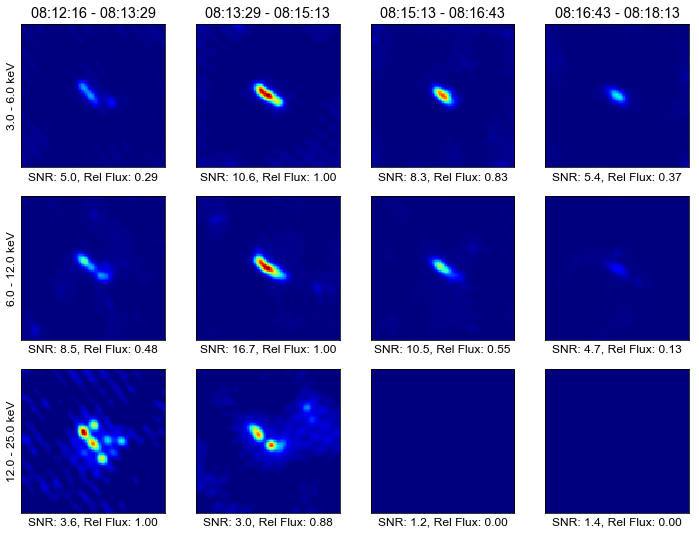

In [8]:
# Sort out the time labels
timlab=[]
for t in np.arange(nt):
    timlab.append(times[t*ne][0].isot[11:19]+' - '+times[t*ne][1].isot[11:19])
# Sort out the energy labels
englab=[]
for ee in np.arange(ne):
    englab.append(str(engs[ee][0])+' - '+str(engs[ee][1])+' keV')
    
# Plot all the maps    
plt.rcParams.update({'font.size': 12,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
# plt.rcParams.update({'font.size': 12,'font.family':"serif",\
#                      'font.serif':"STIXGeneral",'mathtext.default':"regular"})
fig, ax = plt.subplots(nrows=ne, ncols=nt,figsize=(nt*3, ne*3))
# Load in the RHESSI color table (maybe not the best here?)
cmap = plt.get_cmap('rhessi')
# Loop over all the maps and plot
for tt in np.arange(nt):
    for ee in np.arange(ne):
        ax[ee,tt].set_xticks([])
        ax[ee,tt].set_yticks([])
        ax[ee,tt].imshow(imgs[tt,ee,:,:],origin='lower',vmin=0.,vmax=maxs[ee],cmap=cmap)
        if (ee == 0):
            ax[ee,tt].set_title(timlab[tt])
        if (tt == 0):
            ax[ee,tt].set_ylabel(englab[ee]) 
        ax[ee,tt].set_xlabel('SNR: '+"%0.1f" % snr[tt*ne+ee]+\
                             ', Rel Flux: '+"%0.2f" % relflux[tt,ee])    
plt.show()